# Определение перспективного тарифа для телеком компании

## <a id="0.0"></a>Содержание:

* [1. Знакомство с данными, предварительная обработка данных.](#1.)
    * [1.1. Таблица users.](#1.1.)
    * [1.2. Таблица calls.](#1.2.)
    * [1.3. Таблица internet.](#1.3.)
    * [1.4. Таблица messages.](#1.4.)
    * [1.5. Таблица tariffs.](#1.5.)
* [2. Подсчет дополнительных показателей для каждого пользователя.](#2.)
* [3. Анализ данных.](#3.)
    * [3.1. Переплаты за доп.трафик и выручка по выборке.](#3.1.)
    * [3.2. Анализ звонков, смс и интернет-трафика.](#3.2.)
* [4. Проверка гипотез.](#4.)
    * [4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.](#4.1.)
    * [4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.](#4.2.)
* [5. Общий вывод.](#5.)

## 1. Знакомство с данными, предварительная обработка.<a name="1."></a>
[к содержанию](#0.0)

In [2]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# считаем датасеты
users = pd.read_csv('datasets/users.csv')
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')

Познакомимся детально с каждым датасетом и проведем предобработку данных.

## 1.1. Таблица users. <a name="1.1."></a>
[к содержанию](#0.0)

In [4]:
# используя методы head, describe, info, ознакомимся с общей информацией о таблице
print(users.head()), print()
print(users.describe()), print()
print(users.info()), print()

   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  

           user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id   

(None, None)

Метод describe указывает на отсутствие выбросов в поле age. Проверим на корректность поле **reg_date** и **churn_date**, заодно изменим тип данных на datetime.

In [5]:
# изменим тип данных в полях
users.reg_date = pd.to_datetime(users.reg_date)
users.churn_date = pd.to_datetime(users.churn_date)

In [6]:
# проверим наличие выбросов, посмотрим минимальые и максимальные значения
print('Минимальное значение даты регистрации:', pd.to_datetime(users.reg_date).min())
print('Максимальное значение даты регистрации:', pd.to_datetime(users.reg_date).max())
print('Минимальное значение даты прекращения пользованием:', pd.to_datetime(users.churn_date).min())
print('Максимальное значение даты прекращения пользованием:', pd.to_datetime(users.churn_date).max())

Минимальное значение даты регистрации: 2018-01-01 00:00:00
Максимальное значение даты регистрации: 2018-12-31 00:00:00
Минимальное значение даты прекращения пользованием: 2018-08-17 00:00:00
Максимальное значение даты прекращения пользованием: 2018-12-30 00:00:00


Как видно, выбросов в датах нет, все данные действительно за 2018 год. В поле **churn_date** есть пропущенные значения, но, как указано в описании полей, если значение пропущено, то тариф ещё действовал на момент выгрузки.
Проверим данные на дубликаты и уникальность id пользователей.

In [7]:
# проверим уникальность user_id
print('К-во уникальных пользователей:', users.user_id.nunique())

К-во уникальных пользователей: 500


К-во уникальных **user_id** - 500, это значит, что полных дубликатов в таблице нет.

## 1.2. Таблица calls<a name="1.2."></a>
[к содержанию](#0.0)

In [8]:
# используя методы head, describe, info, ознакомимся с общей информацией о таблице
print(calls.head()), print()
print(calls.describe()), print()
print(calls.info()), print()

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None



(None, None)

Пропущенные значения отсутствуют, изменим тип данных в поле **call_date** на datetime.

In [9]:
calls.call_date = pd.to_datetime(calls.call_date)

Метод head говорит нам о том, что длительность в **duration** не округлена до одной минуты, как указано в документации, сделаем это

In [10]:
calls.duration = calls.duration.apply(np.ceil)

Метод describe показал нам, что минимальное значение - 0 секунд, посмотрим распределение по данному полю более подробно

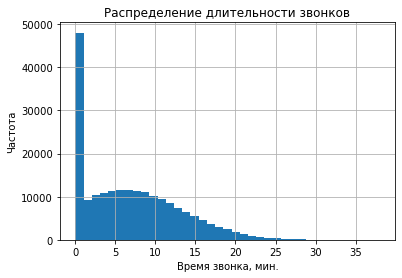

In [11]:
# посмтроим гистограмму распределениея длительности звонков
calls.duration.hist(bins=37)
plt.title("Распределение длительности звонков")
plt.xlabel("Время звонка, мин.")
plt.ylabel("Частота")
plt.show()

In [12]:
# проверим нулевые значения
print('К-во нулевых значений в duration:', calls[calls.duration == 0]['duration'].count())

К-во нулевых значений в duration: 39613


Посмотрим, как нулевые звонки распределяются по пользователям и по тарифам

In [13]:
# проверим распределение по пользователям
calls[calls.duration == 0].groupby('user_id')['user_id'].count().sort_values(ascending=False)

user_id
1377    336
1168    308
1453    295
1375    290
1196    262
       ... 
1206      6
1442      5
1406      5
1084      5
1424      5
Name: user_id, Length: 492, dtype: int64

In [14]:
# проверим распределение по тарифам
calls[calls.duration == 0].merge(users, on='user_id').groupby('tariff')['user_id'].count()

tariff
smart    25669
ultra    13944
Name: user_id, dtype: int64

In [15]:
calls[calls.duration == 0].merge(users, on = 'user_id')

,id,call_date,duration,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,0.0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,0.0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_5,2018-11-02,0.0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_6,2018-10-18,0.0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_9,2018-08-15,0.0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...
39608,1499_203,2018-12-03,0.0,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
39609,1499_205,2018-10-13,0.0,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
39610,1499_206,2018-12-26,0.0,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
39611,1499_207,2018-10-28,0.0,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


In [16]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Судя по распределению, нулевые значения не сконцентрированы у одних и тех же пользователей или в одних и тех же тарифах.

Можем предположить, что такие значения являются несостоявшимися разговорами, например, когда номер был занят или абонент был вне зоны действия сети.

В таком случае, так как данные звонки не используют минуты трафика и будут только мешать при анализе, можем удалить их из таблицы.

In [17]:
# оставим в таблице только строки со значением >= 1 минуте
calls = calls[calls.duration > 0]

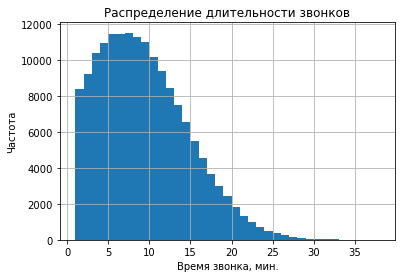

In [18]:
# повторно построим гистограмму распределения длительности звонков
calls.duration.hist(bins=37)
plt.title("Распределение длительности звонков")
plt.xlabel("Время звонка, мин.")
plt.ylabel("Частота")
plt.show()

## 1.3. Таблица internet<a name="1.3."></a>
[к содержанию](#0.0)

In [19]:
# используя методы head, describe, info, ознакомимся с общей информацией о таблице
print(internet.head()), print()
print(internet.describe()), print()
print(internet.info()), print()

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000

          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    1493

(None, None)

Пропуски отсутствуют. Как и в случае с таблицей calls, заменим тип данных в **session_date** на datetime, округлим **mb_used** до целых.

In [20]:
internet.session_date = pd.to_datetime(internet.session_date)
internet.mb_used = internet.mb_used.apply(np.ceil)

Посмотрим на гистаграмму распределения **mb_used**, там также есть нули, судя по describe.

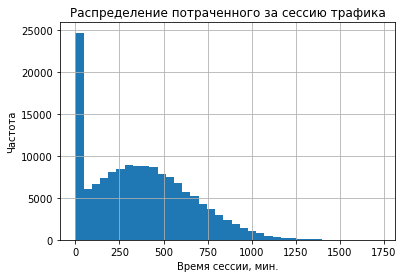

In [21]:
# построим гистограмму распределения интернет-сессии по длительности
internet.mb_used.hist(bins=37)
plt.title("Распределение потраченного за сессию трафика")
plt.xlabel("Время сессии, мин.")
plt.ylabel("Частота")
plt.show()

In [22]:
# посмотрим на количество сессий с нулевым временем
print('К-во сессий с нулевым временем:', internet[internet.mb_used == 0]['mb_used'].count())

К-во сессий с нулевым временем: 19598


Можно предположить, что это те сессии, когда интернет обрывается и пользователь не успевает загрузить ни одной web-страницы. Так как они тоже не будут участвовать в анализе, удалим их из таблицы.

In [23]:
internet = internet[internet.mb_used > 0]

## 1.4. Таблица messages<a name="1.4."></a>
[к содержанию](#0.0)

In [24]:
# используя методы head, info, ознакомимся с общей информацией о таблице
print(messages.head()), print()
print(messages.info()), print()

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None



(None, None)

В таблице отсутствуют пропуски, осталось лишь заменить тип данных **message_date** на datetime.

In [25]:
messages.message_date = pd.to_datetime(messages.message_date)

## 1.5. Таблица tariffs<a name="1.5."></a>
[к содержанию](#0.0)

In [26]:
# используя методы head, describe, info, ознакомимся с общей информацией о таблице
print(tariffs.head()), print()
print(tariffs.info()), print()

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tarif

(None, None)

Таблица содержит лишь общую информацию, характеризующую каждый тариф, пропусков и ошибок нет.

## Вывод

В первом шаге мы познакомились с данными, изменили типы данных на datetime в полях, где была указана дата, обнаружили пропущенные значения в **churn_date**, но, как указано в описании проекта, они обусловлены тем, что тариф действует на момент выгрузки. Таблица **users** проверена на дубликаты - user_id уникальны, значит, дубликатов нет.

В полях **duration** и **mb_used** значения минут и мегабайт были округлены вверх, как указано в описании проекта. Также в этих полях были обнаружены нулевые значения. Нулевые значения в **duration** могут быть связаны с несостоявшимися разговорами, например, когда номер был занят или абонент был вне зоны действия сети. Нулевые значения в **mb_used** могут быть обусловлены тем, что в таких случаях интернет обрывается и пользователь не успевает загрузить ни одной web-страницы.
Данные значения были удалены из выборок, чтобы не искажать результаты анализа.

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА:</b> 
    
    
Молодец, очень даже хороший обзор и предобработка, молодец


</div>

## 2. Подсчет дополнительных показателей для каждого пользователя.   <a name="2."></a>
[к содержанию](#0.0)

* количество сделанных звонков и израсходованных минут разговора по месяцам;  
* количество отправленных сообщений по месяцам;  
* объем израсходованного интернет-трафика по месяцам;  
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
    

Для начала добавим в датасеты **calls, internet, messages** дополнительное поле с месяцем.

In [27]:
# добавим поля с месяцами в датасеты
calls['month'] = calls.call_date.dt.month
internet['month'] = internet.session_date.dt.month
messages['month'] = messages.message_date.dt.month

Для каждого клиента посчитаем израсхдованный трафик по месяцам.

In [28]:
# посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам
clients_calls_traffic = calls.groupby(['user_id', 'month']).\
    agg({'call_date' : 'count', 'duration' : 'sum'}).\
    rename(columns={'call_date' : 'calls_count', 'duration' : 'minutes_sum'})

# посчитаем количество израсходованного интернет-трафика по месяцам
clients_internet_traffic = internet.groupby(['user_id', 'month']).\
    agg({'mb_used' : 'sum'}).rename(columns={'mb_used' : 'mb_used_sum'})

# посчитаем количество отправленных сообщений
clients_messages_traffic = messages.groupby(['user_id', 'month']).\
    agg({'id' : 'count'}).rename(columns={'id' : 'messages_count'})

Объединим полученные таблицы, добавим информацию из таблицы tariffs для расчета выручки.

In [29]:
# применим метод concat и объединим таблицы с расчетами
clients_pivot = \
    pd.concat([clients_calls_traffic, clients_internet_traffic, clients_messages_traffic], axis=1).reset_index()

# добавим информацию из таблицы tariffs
clients_pivot = clients_pivot.merge(users[['user_id', 'tariff', 'city']]).\
    merge(tariffs, left_on='tariff', right_on='tariff_name')

# удалим лишний столбец с названием тарифа
clients_pivot.drop(['tariff_name'], axis = 1, inplace=True)

Посмотрим полученный датасет.

In [30]:
clients_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   calls_count            3168 non-null   float64
 3   minutes_sum            3168 non-null   float64
 4   mb_used_sum            3201 non-null   float64
 5   messages_count         2717 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
dtypes: f

Как видно, в некоторых полях есть пропуски, это связано с тем, что некоторые клиенты могли не использовать те или иные инструменты тарифа в определенные месяцы, например, совсем не отправлять смс.

Заменим пропуски на ноли, для дальнейшего корректного подсчета выручки.

In [31]:
clients_pivot =  clients_pivot.fillna(0)

Посчитаем к-во трафика, которое использовал клиент сверх лимита, включенного в тариф.

In [32]:
# посчитаем к-во трафика, которое использует клиент сверх лимита
clients_pivot['minutes_over_limit'] = clients_pivot.minutes_sum - clients_pivot.minutes_included
clients_pivot['messages_over_limit'] = clients_pivot.messages_count - clients_pivot.messages_included
clients_pivot['internet_over_limit'] = clients_pivot.mb_used_sum - clients_pivot.mb_per_month_included

# добавим трафик сверх лимита в Гб с окрулением в большую сторону для расчета выручки
clients_pivot['internet_over_limit_gb'] = \
    ((clients_pivot.mb_used_sum - clients_pivot.mb_per_month_included) / 1024).apply(np.ceil)

# заменим отрицательные значения на 0
clients_pivot[['minutes_over_limit', 'internet_over_limit', 'messages_over_limit', 'internet_over_limit_gb' ]] = \
clients_pivot[['minutes_over_limit', 'internet_over_limit', 'messages_over_limit', 'internet_over_limit_gb' ]].clip(lower=0)

Посчитаем выручку для каждого клиента по месяцам.

In [33]:
clients_pivot['revenue'] = (
    clients_pivot.minutes_over_limit * clients_pivot.rub_per_minute +
    clients_pivot.internet_over_limit_gb * clients_pivot.rub_per_gb + 
    clients_pivot.messages_over_limit * clients_pivot.rub_per_message +
    clients_pivot.rub_monthly_fee
)

In [34]:
clients_pivot.sort_values(by='user_id').reset_index(drop=True).head(10)

,user_id,month,calls_count,minutes_sum,mb_used_sum,messages_count,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over_limit,messages_over_limit,internet_over_limit,internet_over_limit_gb,revenue
0,1000,5,17.0,159.0,2256.0,22.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,23257.0,60.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,14016.0,75.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,14070.0,81.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,14581.0,57.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
5,1000,10,44.0,350.0,14717.0,73.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
6,1000,11,37.0,338.0,14768.0,58.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
7,1000,12,38.0,333.0,9827.0,70.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
8,1001,12,47.0,414.0,14053.0,0.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,0.0,0.0,550.0
9,1001,11,45.0,430.0,18452.0,0.0,smart,Москва,50,15360,500,550,200,3,3,0.0,0.0,3092.0,4.0,1350.0


Приведем объемы услуг и выручку к целочисленному типу int

In [35]:
clients_pivot = clients_pivot.astype(int, errors='ignore')

#### Вывод

Во втором шаге мы произвели дополнительные расчеты по каждому клиенту по месяцам. Эти показатели понадобятся нам для дальнейшего анализа и проверки гипотез.

## 3. Анализ данных.<a name="3."></a>
[к содержанию](#0.0)

## 3.1. Переплаты за доп.трафик и выручка по выборке.<a name="3.1."></a>
[к содержанию](#0.0)

В прошлом шаге мы вывели информацию о выручке с клиентов за каждый месяц. Интересно проверить, в каком из тарифов клиенты чаще заказывают дополнительные услуги и переплачивают сверх абонентской платы. 

Также можно посмотреть, какой из тарифов в выборке принес большую выручку.

Выведем столбец с суммой переплат за месяц сверх абонентской платы тарифа. 
Также добавим поле с маркером, была переплата или нет, чтобы оценить в каких тарифах клинеты больше переплачивали.

In [36]:
# добавим поле с суммой переплаты сверх абонентской платы за тариф
clients_pivot['over_the_fee'] = clients_pivot.revenue - clients_pivot.rub_monthly_fee

# добавим признак, была ли переплата у клиента или нет
clients_pivot['is_over_the_fee']  = np.where(clients_pivot['over_the_fee'] > 0, 1, 0)

In [37]:
# проагрегируем данные, чтобы посчитать процент тех клиентов, которые заказывали доп. услуги
over_the_fee = clients_pivot.groupby('tariff').agg({'user_id' : 'count', 'is_over_the_fee' : 'sum'})\
    .rename(columns = {'user_id' : 'count', 'is_over_the_fee' : 'sum' }).reset_index()

# произведем подсчет долей
over_the_fee['Заказ дополнительных услуг'] = over_the_fee['sum'] / over_the_fee['count'] 
over_the_fee['В рамках тарифа'] = 1 - over_the_fee['Заказ дополнительных услуг'] 
over_the_fee = over_the_fee[['tariff','Заказ дополнительных услуг', 'В рамках тарифа']]

In [38]:
print('\033[1m' + 'Заказ дополнительных услуг по тарифам:' +  '\033[0m'), print()
print(over_the_fee)

Заказ дополнительных услуг по тарифам:

  tariff  Заказ дополнительных услуг  В рамках тарифа
0  smart                    0.746972         0.253028
1  ultra                    0.136041         0.863959


Как видно, доля заказа дополнительных услуг для разных тарифов отличается, отобразим на графиках для наглядности.

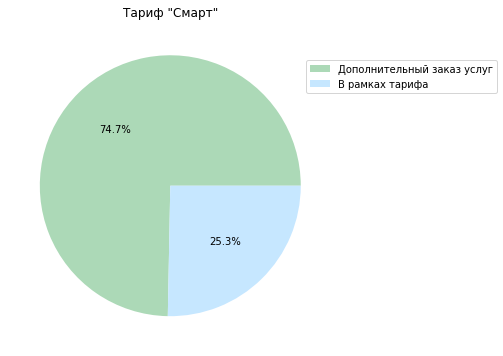

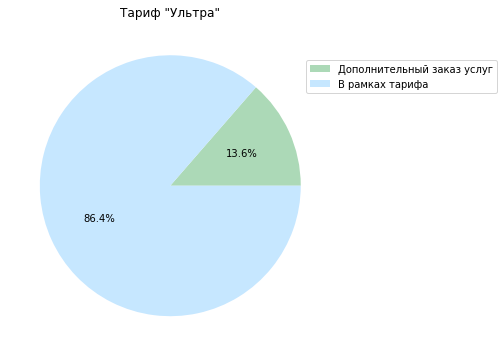

In [39]:
# транспонируем таблицу для вывода гистограмм по тарифам
df_plot = over_the_fee.T.iloc[1:3]

# круговая гистограмма по тарифу Смарт
colors = ['#acd9b7', '#c6e7ff']
plot = df_plot.\
plot(kind='pie',  y=0, labels=None, figsize=(6,6), title='Тариф "Смарт"', colors=colors, autopct='%.1f%%')
plot.set_ylabel('')
plot.legend(['Дополнительный заказ услуг', 'В рамках тарифа'],bbox_to_anchor=(0.9,0.9))
plt.show()

# круговая гистограмма по тарифу Ультра
plot = df_plot.\
plot(kind='pie',  y=1, labels=None, figsize=(6,6), title='Тариф "Ультра"', colors=colors, autopct='%.1f%%')
plot.set_ylabel('')
plot.legend(['Дополнительный заказ услуг', 'В рамках тарифа'],bbox_to_anchor=(0.9,0.9))
plt.show()

Посмотрим, какие услуги дополнительно чаще заказывают пользователи и сколько в среднем переплачивают.

In [40]:
# посчитаем среднее по переплатам
clients_over_pivot = clients_pivot.groupby('tariff').agg({'minutes_over_limit' : 'mean',
                                                         'messages_over_limit' : 'mean',
                                                         'internet_over_limit_gb' : 'mean'})


clients_over_pivot = clients_over_pivot.reset_index()
# округлим в большую сторону все превышения лимита
clients_over_pivot.iloc[:,1:] = clients_over_pivot.iloc[:,1:].apply(np.ceil)

# добавим инфо из тарифа для расчета переплат
cost = pd.DataFrame(np.array([[3, 3, 200],[1, 1, 150]]),
                   columns=['minutes_rub', 'messages_rub', 'internet_rub'])

# посчитаем переплаты за доп. услуги по тарифам
clients_over_pivot['minutes_over_rub'] = clients_over_pivot['minutes_over_limit'] * cost['minutes_rub']
clients_over_pivot['messages_over_rub'] = clients_over_pivot['messages_over_limit'] * cost['messages_rub']
clients_over_pivot['internet_over_rub_gb'] = clients_over_pivot['internet_over_limit_gb'] * cost['internet_rub']

In [41]:
clients_over_pivot

,tariff,minutes_over_limit,messages_over_limit,internet_over_limit_gb,minutes_over_rub,messages_over_rub,internet_over_rub_gb
0,smart,42.0,6.0,4.0,126.0,18.0,800.0
1,ultra,0.0,0.0,1.0,0.0,0.0,150.0


Проверим, какой тариф, согласно нашей выборке, за год принес большую выручку.

In [42]:
# сгруппируем по тарифу и посчитаем сумму выручки
year_revenue = clients_pivot.groupby('tariff').agg({'revenue' : 'sum', 'user_id' : 'nunique'}).reset_index()

# добавим поле с процентом от общей суммы
year_revenue['persent'] = year_revenue['revenue'] / year_revenue['revenue'].sum()

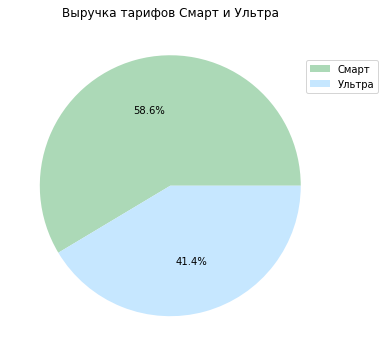

  tariff  revenue  user_id  persent
0  smart  2885751      350  0.58585
1  ultra  2040000      148  0.41415


In [43]:
# круговая гистограмма выручки по тарифам
plot = year_revenue.plot(kind='pie',  y=1, labels=None, figsize=(6,6), \
                  title='Выручка тарифов Смарт и Ультра', colors = colors, autopct='%.1f%%' )
plot.set_ylabel('')
plot.legend(['Смарт', 'Ультра'],bbox_to_anchor=(0.9,0.9))
plt.show()
print(year_revenue)


## Вывод

Из анализа заказа дополнительных услуг видно, что клиентам чаще всего не хватает интернет-трафика, в частности, клиенты **Смарта** переплачивают 800 рублей за дополнительные гигабайты, клиенты **Ультра** в среднем дозаказывают один гигабайт и переплачивают всего 150 рублей. 

Клиентам **Смарта** также не хватает минут разговора, и они дополнительно докупают в среднем 40 минут. Меньше всего клиентам нужны дополнительные смс, что может быть обусловлено популярностью общения в мессенджерах.

Клиенты **Смарт** принесли 2885751 руб. выручки при к-ве пользователей 350, в свою очередь, клиенты **Ультра** принесли 2040000 руб. при 150 пользователях.

In [44]:
# КОД РЕВЬЮВЕРА

users.tariff.value_counts()

# было бы интересно подсчитать именно sales_per_user, когда мы суммарную выручку делим на кол-во уникальных юзеров, тем самым
# понимаем пользователь какого тарифа приносит больше

smart    351
ultra    149
Name: tariff, dtype: int64

## 3.2. Анализ звонков, смс и интернет-трафика.<a name="3.2."></a>
[к содержанию](#0.0)

Проанализируем поведение клиентов исходя из выборки, напишем функцию, которая покажет общую статистику по каждому параметру:
* Количество минут звонков
* Количество смс
* Количество мегабайт

Для начала построим боксплоты по всем типам трафика(звонки, смс, интернет) для каждого тарифа.

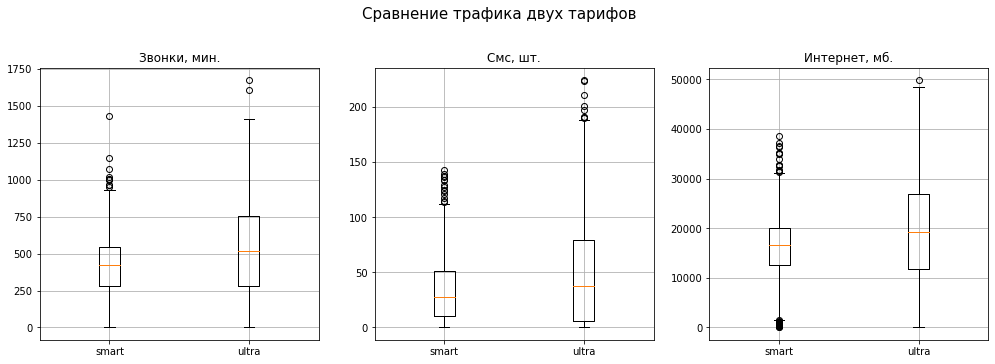

In [45]:
minutes_smart = clients_pivot[clients_pivot['tariff'] == 'smart']['minutes_sum']
minutes_ultra = clients_pivot[clients_pivot['tariff'] == 'ultra']['minutes_sum']

messages_smart = clients_pivot[clients_pivot['tariff'] == 'smart']['messages_count']
messages_ultra = clients_pivot[clients_pivot['tariff'] == 'ultra']['messages_count']

mb_smart = clients_pivot[clients_pivot['tariff'] == 'smart']['mb_used_sum']
mb_ultra = clients_pivot[clients_pivot['tariff'] == 'ultra']['mb_used_sum']

minutes = [minutes_smart, minutes_ultra]
messages = [messages_smart, messages_ultra]
mb = [mb_smart, mb_ultra]
names = ['smart', 'ultra']

plt.figure(figsize=(17, 5))
plt.suptitle('Сравнение трафика двух тарифов', fontsize=15, y=1.05)
traffic_titles = ['Звонки, мин.', 'Смс, шт.', 'Интернет, мб.']
traffic_type = [minutes, messages, mb]

p = 131
for i in range(3):
    plt.subplot(p)
    plt.boxplot(traffic_type[i], labels=names)
    plt.grid()
    plt.title(traffic_titles[i])
    p += 1
plt.show()

По графикам видно, что данные имеют выбросы > 1,5 межквартильных размаха, определим эти интервалы. Далее отфильтруем данные от выбросов для более корректного анализа.

In [46]:
# функция покажет межквартильный размах по каждому параметру
def iqr(df, column, category_column, category, equal):
    if equal == 'equal':
        col = df[df[category_column] == category][column]
    elif equal == 'not_equal':
        col = df[df[category_column] != category][column]
    iqr = col.describe()[6] - col.describe()[4]
    low_bond = col.describe()[4] - 1.5 * iqr
    if low_bond < 0:
        low_bond = col.describe()[3]
    upper_bond = col.describe()[6] + 1.5 * iqr
    print('{} - {}'.format(low_bond, upper_bond))

In [47]:
# найдем границы интервалов
print('\033[1m' + 'Границы интервалов по Звонкам, мин' +  '\033[0m')
print('Смарт:', end=' '), iqr(clients_pivot, 'minutes_sum', 'tariff', 'smart', 'equal')
print('Ультра:', end=' '), iqr(clients_pivot, 'minutes_sum', 'tariff', 'ultra', 'equal')
print()
print('\033[1m' + 'Границы интервалов по Смс, шт' + '\033[0m')
print('Смарт:', end=' '), iqr(clients_pivot, 'messages_count', 'tariff', 'smart', 'equal')
print('Ультра:', end=' '), iqr(clients_pivot, 'messages_count', 'tariff', 'ultra', 'equal')
print()
print('\033[1m' + 'Границы интервалов по Интернет, мб' + '\033[0m')
print('Смарт:', end=' '), iqr(clients_pivot, 'mb_used_sum', 'tariff', 'smart', 'equal')
print('Ультра:', end=' '), iqr(clients_pivot, 'mb_used_sum', 'tariff', 'ultra', 'equal')
print()

Границы интервалов по Звонкам, мин
Смарт: 0.0 - 939.5
Ультра: 0.0 - 1454.0

Границы интервалов по Смс, шт
Смарт: 0.0 - 112.5
Ультра: 0.0 - 188.5

Границы интервалов по Интернет, мб
Смарт: 1543.0 - 31183.0
Ультра: 0.0 - 49480.0



Сделаем фильтрацию по выявленным интервалам и уберем выбросы

In [48]:
# отфильтруем звонки от выбросов
smart_minutes = clients_pivot.query("minutes_sum <= 939.5 & tariff == 'smart'")['minutes_sum']
ultra_minutes = clients_pivot.query("minutes_sum <= 3000 & tariff == 'ultra'")['minutes_sum']

# отфильтруем сообщения от выбросов
smart_messages = clients_pivot.query("messages_count <= 112.5 & tariff == 'smart'")['messages_count']
ultra_messages = clients_pivot.query("messages_count <= 1000 & tariff == 'ultra'")['messages_count']

# отфильтруем интернет трафик от выбросов
smart_mb_used = clients_pivot.query("mb_used_sum <= 31183 & tariff == 'smart'")['mb_used_sum']
ultra_mb_used = clients_pivot.query("mb_used_sum <= 49480 & tariff == 'ultra'")['mb_used_sum']

Изобразим трафик звонков каждого тарифа на одном графике и выведем описательные статистики.

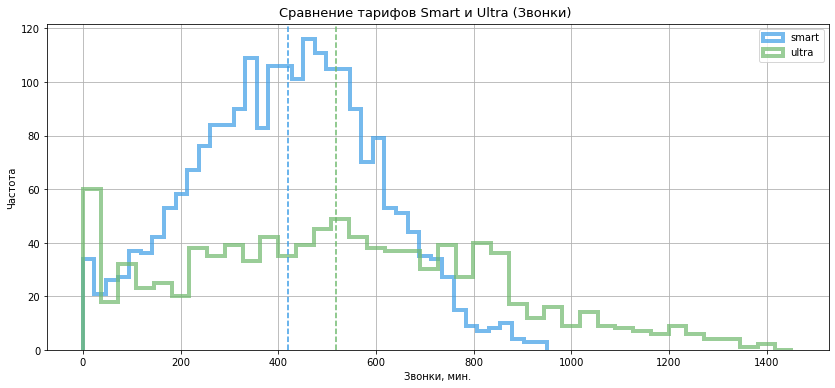

Описательные статистики для звонков тарифа Smart

Дисперсия: 34448

count    2219.00000
mean      415.05498
std       185.60219
min         0.00000
25%       282.00000
50%       421.00000
75%       544.00000
max       933.00000
Name: minutes_sum, dtype: float64

Описательные статистики для звонков тарифа Ultra

Дисперсия: 100874

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes_sum, dtype: float64


In [49]:
# построим график для тарифа смарт
ax = smart_minutes.plot(kind='hist', y='minutes_sum', range=(0, 950), bins=40, linewidth=4, alpha=0.7, label='smart',\
                histtype='step', color='#3c9de6')

# построим график для тарифа ультра
ultra_minutes.plot(kind='hist', y='minutes_sum', range=(0, 1454), bins=40, linewidth=4, alpha=0.7, label='ultra',\
           histtype='step',  ax=ax, grid=True, legend=True, figsize = (14,6), color='#6fb96d')

# определим общие графика настройки 
plt.suptitle('Сравнение тарифов Smart и Ultra (Звонки)', fontsize=13, y=0.92)
plt.axvline(x=smart_minutes.median(), color='#3c9de6', linestyle='--')
plt.axvline(x=ultra_minutes.median(), color='#6fb96d', linestyle='--')
plt.xlabel("Звонки, мин.")
plt.ylabel("Частота")
plt.legend()
plt.show()

# добавим под графиком описательные статистики
print('\033[1m' + 'Описательные статистики для звонков тарифа Smart' + '\033[0m')
print()
print('Дисперсия:', round(smart_minutes.var()))
print()
print(smart_minutes.describe())
print()
print('\033[1m' + 'Описательные статистики для звонков тарифа Ultra' + '\033[0m')
print()
print('Дисперсия:', round(ultra_minutes.var()))
print()
print(ultra_minutes.describe())

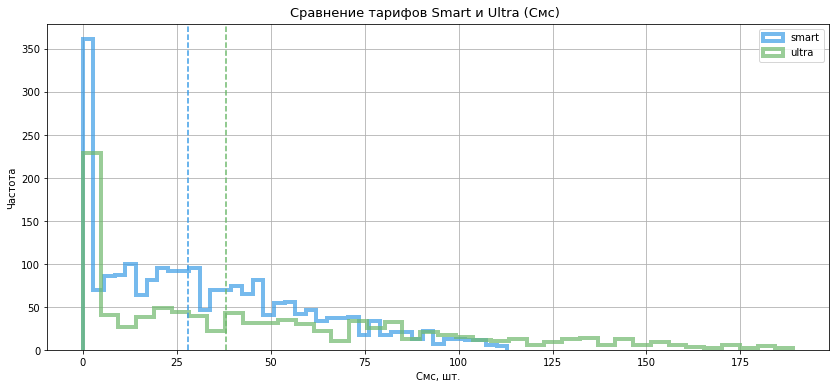

Описательные статистики для смс тарифа Smart

Дисперсия: 744

count    2215.000000
mean       32.784650
std        27.278551
min         0.000000
25%        10.000000
50%        28.000000
75%        50.000000
max       112.000000
Name: messages_count, dtype: float64

Описательные статистики для смс тарифа Ultra

Дисперсия: 2285

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64


In [50]:
# построим график для тарифа смарт
ax = smart_messages.plot(kind='hist', y='minutes_sum', range=(0, 113), bins=40, linewidth=4, alpha=0.7, label='smart',\
                histtype='step', color='#3c9de6')

# построим график для тарифа ультра
ultra_messages.plot(kind='hist', y='minutes_sum', range=(0, 189), bins=40, linewidth=4, alpha=0.7, label='ultra',\
           histtype='step',  ax=ax, grid=True, legend=True, figsize = (14,6), color='#6fb96d')

# определим общие графика настройки 
plt.suptitle('Сравнение тарифов Smart и Ultra (Смс)', fontsize=13, y=0.92)
plt.axvline(x=smart_messages.median(), color='#3c9de6', linestyle='--')
plt.axvline(x=ultra_messages.median(), color='#6fb96d', linestyle='--')
plt.xlabel("Смс, шт.")
plt.ylabel("Частота")
plt.legend()
plt.show()

# добавим под графиком описательные статистики
print('\033[1m' + 'Описательные статистики для смс тарифа Smart' + '\033[0m')
print()
print('Дисперсия:', round(smart_messages.var()))
print()
print(smart_messages.describe())
print()
print('\033[1m' + 'Описательные статистики для смс тарифа Ultra' + '\033[0m')
print()
print('Дисперсия:', round(ultra_messages.var()))
print()
print(ultra_messages.describe())

Сразу бросается в глаза, что на обоих тарифах значимая доля клиентов почти не отправляет смс. 
В среднем на тарифе **Smart** клиенты не дотягивают до  своего месячного лимита в 50 смс и отправляют всего 32. 
На тарифе **Ultra** клиенты также практически не используют весь потенциал лимита в 1000 и отправляют по 48 смс в среднем. 

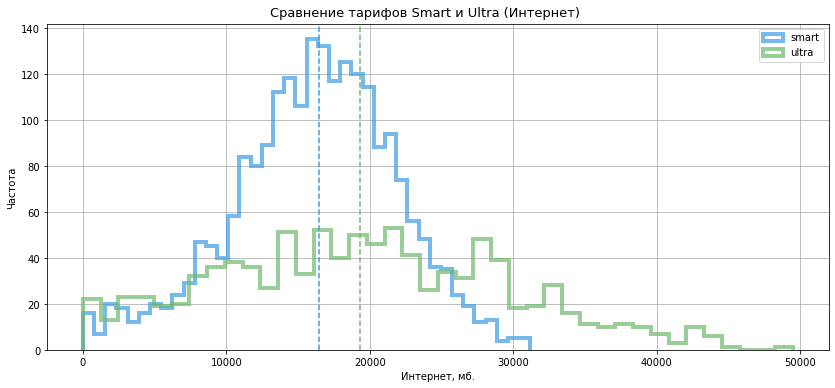

Описательные статистики для интернет-трафика тарифа Smart

Дисперсия: 32648892

count     2215.000000
mean     16114.801354
std       5713.920904
min          0.000000
25%      12632.500000
50%      16484.000000
75%      20005.500000
max      31115.000000
Name: mb_used_sum, dtype: float64

Описательные статистики для интернет-трафика тарифа Ultra

Дисперсия: 101104273

count      984.000000
mean     19456.106707
std      10055.062080
min          0.000000
25%      11777.000000
50%      19320.000000
75%      26854.750000
max      48395.000000
Name: mb_used_sum, dtype: float64


In [51]:
# построим график для тарифа смарт
ax = smart_mb_used.plot(kind='hist', y='minutes_sum', range=(0, 31183.0), bins=40, linewidth=4, alpha=0.7, label='smart',\
                histtype='step', color='#3c9de6')

# построим график для тарифа ультра
ultra_mb_used.plot(kind='hist', y='minutes_sum', range=(0, 49480.0), bins=40, linewidth=4, alpha=0.7, label='ultra',\
           histtype='step',  ax=ax, grid=True, legend=True, figsize = (14,6), color='#6fb96d')

# определим общие графика настройки 
plt.suptitle('Сравнение тарифов Smart и Ultra (Интернет)', fontsize=13, y=0.92)
plt.axvline(x=smart_mb_used.median(), color='#3c9de6', linestyle='--')
plt.axvline(x=ultra_mb_used.median(), color='#6fb96d', linestyle='--')
plt.xlabel("Интернет, мб.")
plt.ylabel("Частота")
plt.legend()
plt.show()

# добавим под графиком описательные статистики
print('\033[1m' + 'Описательные статистики для интернет-трафика тарифа Smart' + '\033[0m')
print()
print('Дисперсия:', round(smart_mb_used.var()))
print()
print(smart_mb_used.describe())
print()
print('\033[1m' + 'Описательные статистики для интернет-трафика тарифа Ultra' + '\033[0m')
print()
print('Дисперсия:', round(ultra_mb_used.var()))
print()
print(ultra_mb_used.describe())

Клиенты на тарифе **Smart** обычно используют от 13 до 20 гб трафика. Медиана при этом равняется 16,5 гб, т.е. очень часто клиенты превышают месячный лимит, заложенный в тарифе, и как следствие заказывают доп.пакеты интернет-трафика, что также было выявлено ранее на круговых диаграммах.

Клиенты **Ultra** активне пользуются интернетом, медиана 19 гб, при лимите в 30 гб на тарифе.

## Вывод

Из анализа видно, что клиентам тарифа Смарт не хватает интернет-трафика, медиана - 16,5 гб при заложенных в тарифе 15 гб, поэтому пользователи вынуждены заказывать дополнительные гигабайты. 

Важно отметить, что значимая доля клиентов отправляет мало сообщений или не отправляет совсем. Особенно ярко это видно в тарифе Ультра, где при потенциале в 1000 смс клиенты в среднем отправляют всего 50.

На звонках при медиане 421 и лимите 500 звонков видно, как многие клиенты "вылезают" за рамки лимита, из-за чего вынуждены заказывать дополнительные минуты разговора. Клиенты Ультра, напротив, не используют лимит в 3000 минут даже наполовину. 

In [52]:
clients_pivot

,user_id,month,calls_count,minutes_sum,mb_used_sum,messages_count,tariff,city,messages_included,mb_per_month_included,...,rub_per_gb,rub_per_message,rub_per_minute,minutes_over_limit,messages_over_limit,internet_over_limit,internet_over_limit_gb,revenue,over_the_fee,is_over_the_fee
0,1000,5,17,159,2256,22,ultra,Краснодар,1000,30720,...,150,1,1,0,0,0,0,1950,0,0
1,1000,6,28,172,23257,60,ultra,Краснодар,1000,30720,...,150,1,1,0,0,0,0,1950,0,0
2,1000,7,41,340,14016,75,ultra,Краснодар,1000,30720,...,150,1,1,0,0,0,0,1950,0,0
3,1000,8,42,408,14070,81,ultra,Краснодар,1000,30720,...,150,1,1,0,0,0,0,1950,0,0
4,1000,9,46,466,14581,57,ultra,Краснодар,1000,30720,...,150,1,1,0,0,0,0,1950,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30,247,20604,42,smart,Владикавказ,50,15360,...,200,3,3,0,0,5244,6,1750,1200,1
3210,1499,9,8,70,1848,11,smart,Пермь,50,15360,...,200,3,3,0,0,0,0,550,0,0
3211,1499,10,44,449,17809,48,smart,Пермь,50,15360,...,200,3,3,0,0,2449,3,1150,600,1
3212,1499,11,62,612,17984,59,smart,Пермь,50,15360,...,200,3,3,112,9,2624,3,1513,963,1


## 4. Проверка гипотез.<a name="4."></a>
[к содержанию](#0.0)

Проверим 2 гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## 4.1. Гипотеза о равенстве средних двух ген. совокупностей (средняя выручка пользователей тарифов "Ультра" и "Смарт" различается).<a name="4.1."></a>
[к содержанию](#0.0)

Cформулируем гипотезы:

**H0** - Cредняя выручка пользователей тарифа "Смарт" не отличается от средней выручки пользователей тарифа "Ультра".  
**H1** - Средняя выручка пользователей тарифа "Смарт" отличается от средней выручки пользователей тарифа "Ультра".

Построим боксплот по выручке и определим границы выбросов.

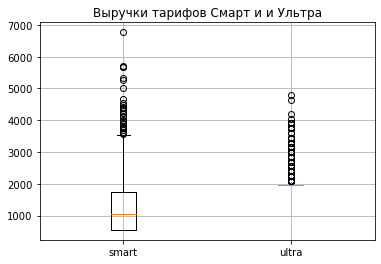


Границы интервалов для фильтрации выбросов:

Смарт: 550.0 - 3550.0
Ультра: 1950.0 - 1950.0



In [54]:
# сформируем выборки по тарифам 
smart_revenue = clients_pivot[clients_pivot['tariff'] == 'smart']['revenue']
ultra_revenue = clients_pivot[clients_pivot['tariff'] == 'ultra']['revenue']

# построим боксплот
plt.boxplot([smart_revenue, ultra_revenue], labels = ['smart', 'ultra'] )
plt.grid()
plt.title('Выручки тарифов Смарт и и Ультра')
plt.show()
print()

# определим границы ранее написанной функцией
print('\033[1m' + 'Границы интервалов для фильтрации выбросов:' +  '\033[0m')
print()
print('Смарт:', end=' '), iqr(clients_pivot, 'revenue', 'tariff', 'smart', 'equal')
print('Ультра:', end=' '), iqr(clients_pivot, 'revenue', 'tariff', 'ultra', 'equal')
print()

In [55]:
# отфильтруем данные от выбросов
smart_revenue = clients_pivot.query("revenue >= 550 & revenue <= 3550 & tariff == 'smart'")['revenue']
ultra_revenue = clients_pivot.query("revenue >= 1950 & revenue <= 1950 & tariff == 'ultra'")['revenue']

In [56]:
# Посчитаем P-value
alpha = .05

results = st.ttest_ind(
    smart_revenue, 
    ultra_revenue)

print('Пороговое значение alpha =', alpha)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Пороговое значение alpha = 0.05
p-значение: 4.6244593528593796e-153
Отвергаем нулевую гипотезу


Так как мы отвергаем нулевую гипотезу и предполагаем, что средняя выручка по тарифам отличается друг от друга, посмотрим, какой тариф приносит большую выручку.

In [57]:
print('Средняя выручка тарифа Смарт:', round(smart_revenue.mean()))
print('Средняя выручка тарифа Ультра:', round(ultra_revenue.mean()))

Средняя выручка тарифа Смарт: 1250
Средняя выручка тарифа Ультра: 1950


Несмотря на большое количество заказов дополнительных услуг (в 75% случаев клиенты заказывают доп. пакеты), пользователи тарифа Смарт приносят меньшуюю выручку из-за довольно большой разницы в абонентской плате тарифов.

#### 4.2. Гипотеза о равенстве средних двух ген. совокупностей (средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов).<a name="4.2."></a>
[к содержанию](#0.0)

Cформулируем гипотезы:

**H0** - cредняя выручка пользователей Москвы не отличается от средней выручки пользователей из других регионов".  
**H1** - Средняя выручка пользователей Москвы отличается от средней выручки пользователей из других регионов".

Отфильтруем данные по Москве и регионам. Построим боксплот по выручке и определим границы выбросов.

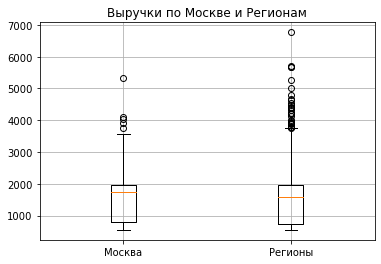


Границы интервалов для фильтрации выбросов:

Москва: 550.0 - 3678.0
Регионы: 550.0 - 3750.0



In [58]:
# сформируем выборки для Москвы и регионов
moscow_revenue = clients_pivot[clients_pivot['city'] == 'Москва']['revenue']
regions_revenue = clients_pivot[clients_pivot['city'] != 'Москва']['revenue']

# построим боксплот
plt.boxplot([moscow_revenue, regions_revenue], labels = ['Москва', 'Регионы'] )
plt.grid()
plt.title('Выручки по Москве и Регионам')
plt.show()
print()

# определим границы ранее написанной функцией
print('\033[1m' + 'Границы интервалов для фильтрации выбросов:' +  '\033[0m')
print()
print('Москва:', end=' '), iqr(clients_pivot, 'revenue', 'city', 'Москва', 'equal')
print('Регионы:', end=' '), iqr(clients_pivot, 'revenue', 'city', 'Москва', 'not_equal')
print()

In [59]:
# отфильтруем данные от выбросов
moscow_revenue = clients_pivot.query("revenue >= 550 & revenue <= 3678 & city == 'Москва'")['revenue']
regions_revenue = clients_pivot.query("revenue >= 550 & revenue <= 3750 & city != 'Москва'")['revenue']

In [60]:
# Посчитаем P-value
alpha = .05

results = st.ttest_ind(
    moscow_revenue, 
    regions_revenue)

print('Пороговое значение alpha =', alpha)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Пороговое значение alpha = 0.05
p-значение: 0.27118563882521046
Не получилось отвергнуть нулевую гипотезу


In [61]:
print('Средняя выручка в Москве:', round(moscow_revenue.mean()))
print('Средняя выручка в Регионах:', round(regions_revenue.mean()))

Средняя выручка в Москве: 1529
Средняя выручка в Регионах: 1492


В Москве в среднем платят на 40 рублей больше, чем в регионах. Разница совсем незначительная. Нельзя сказать, что средняя выручка Москвы отличается от регионов.

## Вывод<a name="5."></a>
[к содержанию](#0.0)

Из анализа видно, что клиентам тарифа Смарт не хватает интернет-трафика - медиана равна 16,5 гб при заложенных в тарифе 15 гб. Поэтому пользователи вынуждены заказывать дополнительные гигабайты - в среднем клиенты Смарта переплачивают 600 рублей. Клиенты Ультры, в свою очередь, переплачивают всего 150 рублей.

Важно отметить, что значимая доля клиентов отправляет мало сообщений или не отправляет совсем. Особенно ярко это видно в тарифе Ультра, где при потенциале в 1000 смс клиенты в среднем отправляют всего 50. Клиенты почти не заказывают дополнительные смс, это может быть обусловлено развитием популярности общения в мессенджерах.

На звонках при медиане 421 и лимите 500 звонков видно, как многие клиенты "вылезают" за рамки лимита, из-за чего вынуждены заказывать в среднем дополнительные 40 минут разговора. Клиенты Ультра, напротив, не расходуют лимит в 3000 минут даже наполовину.

Клиент Ультра приносит 1950 рублей, а клиент Смарт 1250 рублей, несмотря на большее к-во заказа доп.услуг. Это, конечно, обусловлено высокой абонентской платой на тарифе Ультра.

Основные выводы, которые можно сделать:
1. Несмотря на то, что тариф Ультра приносит большую выручку на человека, данный тариф является в сущности "Премуим" тарифом за счет своей высокой абонентской платы. Несмотря на то, что клиентам, как правило, хватает установленных лимитов, он не сможет привлечь большую аудиторию из-за своей стоимости. В свою очередь, тариф Смарт пользуется большой популярностью, но клиенты на нем вынуждены выходить за лимиты и переплачивать за доп.услуги.  
Мегалайн может подумать о введении нового тарифа в среднем (между Смарт и Ультра) ценовом сенменте, на котором клиенты смогут оставаться довольными и не задумываться о лимитах, при этом приносить хорошую выручку компании. 

2. Компании нужно пересмотреть лимиты и сделать больший упор на гигабайты интернет-трафика. Возможно, 1000 смс и является красивой цифрой в рекламном описании тарифа, но на практике никак не бьётся с реальностью - большинству клиентов не требуется такое количество. Также стоит откалибровать лимиты по звонкам на обоих тарифах.



Были проверены 2 гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Выводы которые можно сделать после проверки гипотез:  
1. Средняя выручка по тарифам отличается друг от друга, Смарт - 1250 руб., Ультра - 1950 руб.
2. Средняя выручка Москвы значимо не отличается от выручки по регионам. На выборках разница составила всего 40 рублей.
